### 1. Imports y lectura de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

from utils.embedding import EmbeddingDataset
from utils.vis import plot_1d_predictions, mae_por_class
from utils.roberta_regression import predict_batch_values, load_lora_regression_model

np.set_printoptions(suppress=True)

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
cajcodes = pd.read_parquet("../data/embeddings/cajcodes-embeddings.parquet")
cajcodes = cajcodes.sample(frac=1, random_state=42).reset_index(drop=True)
tweets = pd.read_parquet("../data/embeddings/tweets-embeddings.parquet")

### 3. Entrenamiento sobre ```political-leaning-tweets```

In [4]:
label_map = {"L": -1, "C": 0, "R": 1}
tweets["label"] = tweets["label"].map(label_map)

X = np.vstack(tweets["embedding"].values)
y = tweets["label"].values

#### a. Google Embeddings + Ordinal RidgeReg

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("R^2:", r2, "\n")

mae_per_class = mae_por_class(y_test, y_pred)
for cls, mae_cls in mae_per_class.items():
    print(f"MAE for class {cls}: {mae_cls}")

MAE: 0.5029268787785369
R^2: 0.38108744135824457 

MAE for class L: 0.650361860908343
MAE for class C: 0.2778591179679484
MAE for class R: 0.5808112529919643


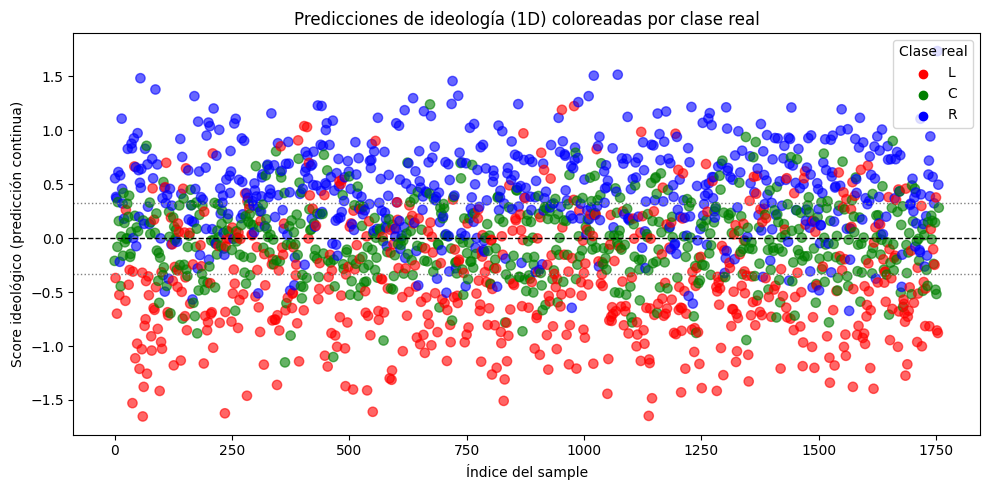

In [6]:
# Convert true numeric labels back to class labels
numeric_to_class = { -1: "L", 0: "C", 1: "R" }
true_classes = np.array([numeric_to_class[v] for v in y_test])

plot_1d_predictions(
    y_pred=y_pred,
    true_labels=true_classes
)

#### b. Google Embeddings + MLP

In [7]:
train_ds = EmbeddingDataset(X_train, y_train)
test_ds  = EmbeddingDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
input_dim = X.shape[1]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1), 
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

mlp_model = MLP(input_dim).to(device)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)

epochs = 100

for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = mlp_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        first_str = f"Epoch {epoch+1}/{epochs}  "
        print(f"{first_str}|  Train Loss: {total_loss/len(train_loader):.4f}")
        # Evaluate on test set
        mlp_model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = mlp_model(xb)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)
        print(f'{" " * len(first_str)}|  Test MAE: {mae:.4f}  |  Test R^2: {r2:.4f}')

Epoch 10/100  |  Train Loss: 0.2179
              |  Test MAE: 0.4410  |  Test R^2: 0.4165
Epoch 20/100  |  Train Loss: 0.0836
              |  Test MAE: 0.4341  |  Test R^2: 0.3593
Epoch 30/100  |  Train Loss: 0.0607
              |  Test MAE: 0.4344  |  Test R^2: 0.3438
Epoch 40/100  |  Train Loss: 0.0483
              |  Test MAE: 0.4274  |  Test R^2: 0.3664
Epoch 50/100  |  Train Loss: 0.0444
              |  Test MAE: 0.4168  |  Test R^2: 0.3692
Epoch 60/100  |  Train Loss: 0.0386
              |  Test MAE: 0.4175  |  Test R^2: 0.3584
Epoch 70/100  |  Train Loss: 0.0361
              |  Test MAE: 0.4162  |  Test R^2: 0.3593
Epoch 80/100  |  Train Loss: 0.0369
              |  Test MAE: 0.4073  |  Test R^2: 0.3556
Epoch 90/100  |  Train Loss: 0.0313
              |  Test MAE: 0.4039  |  Test R^2: 0.3558
Epoch 100/100  |  Train Loss: 0.0324
               |  Test MAE: 0.4092  |  Test R^2: 0.3381


In [9]:
mae_per_class = mae_por_class(all_labels, all_preds)
for cls, mae_cls in mae_per_class.items():
    print(f"MAE for class {cls}: {mae_cls}")

MAE for class L: 0.5325310230255127
MAE for class C: 0.2223474085330963
MAE for class R: 0.4728925824165344


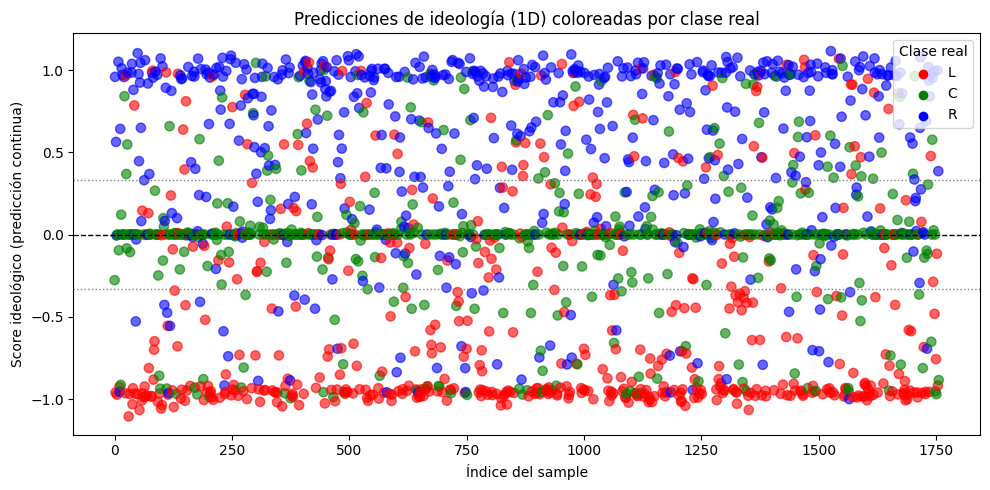

In [10]:
plot_1d_predictions(
    y_pred=all_preds,
    true_labels=true_classes
)

### 4. Evaluación de modelos en ```cajcodes```

Se decidió entrenar en tweets y evaluar en cajcodes dado que el segundo es más sencillo de predecir, dado que está generado con GPT.

In [11]:
X_caj = np.vstack(cajcodes["embedding"].values)
y_caj = cajcodes["label"].values
y_caj_num = np.array([label_map[l] for l in y_caj], dtype=float)

#### a. RidgeReg

In [12]:
y_caj_pred_ridge = ridge_model.predict(X_caj)
mae_ridge = mean_absolute_error(y_caj_num, y_caj_pred_ridge)
r2_ridge = r2_score(y_caj_num, y_caj_pred_ridge)
mae_class_ridge = mae_por_class(y_caj_num, y_caj_pred_ridge)

print("=== Ridge en cajcodes ===")
print(f"MAE global: {mae_ridge:.4f}")
print(f"R^2 global: {r2_ridge:.4f}, \n")
for cls, mae_cls in mae_class_ridge.items():
    print(f"MAE for class {cls}: {mae_cls}")

=== Ridge en cajcodes ===
MAE global: 0.7535
R^2 global: -0.1845, 

MAE for class L: 0.3918885191299032
MAE for class C: 0.6839182430088191
MAE for class R: 1.0771541552397368


#### b. MLP

In [13]:
caj_ds = EmbeddingDataset(X_caj, y_caj_num)
caj_loader = DataLoader(caj_ds, batch_size=32, shuffle=False)

mlp_model.to(device)
mlp_model.eval()

y_caj_pred_mlp = []
all_true_caj = []

with torch.no_grad():
    for xb, yb in caj_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        preds = mlp_model(xb)
        y_caj_pred_mlp.extend(preds.cpu().numpy())
        all_true_caj.extend(yb.cpu().numpy())

all_preds_caj = np.array(y_caj_pred_mlp)
all_true_caj = np.array(all_true_caj)

In [14]:
mae_mlp = mean_absolute_error(all_true_caj, all_preds_caj)
r2_mlp = r2_score(all_true_caj, all_preds_caj)
mae_class_mlp = mae_por_class(all_true_caj, all_preds_caj)

print("\n=== MLP en cajcodes ===")
print(f"MAE global: {mae_mlp:.4f}")
print(f"R^2 global: {r2_mlp:.4f}\n")
for cls, mae_cls in mae_class_mlp.items():
    print(f"MAE for class {cls}: {mae_cls}")


=== MLP en cajcodes ===
MAE global: 0.7883
R^2 global: -0.4462

MAE for class L: 0.19804251194000244
MAE for class C: 0.7369764447212219
MAE for class R: 1.2689107656478882


### c) BERT based model

In [15]:
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased")
bert_model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")
bert_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
def political_score_batch(texts):
    inputs = tokenizer_bert(texts, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = bert_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1).numpy()

    # asumimos orden [L, C, R]
    scores = probs[:,2] - probs[:,0]
    return scores, probs

In [17]:
y_true = np.array([label_map[v] for v in cajcodes["label"].values])
texts = cajcodes["text"].tolist()

y_pred_bert, y_probs = political_score_batch(texts)
mae_bert = mean_absolute_error(y_true, y_pred_bert)
r2_bert = r2_score(y_true, y_pred_bert)
mae_class_bert = mae_por_class(y_true, y_pred_bert)

print("\n=== Pretrained BERT (HF) en cajcodes ===")
print(f"MAE global: {mae_bert:.4f}")
print(f"R^2 global: {r2_bert:.4f}\n")
for cls, mae_cls in mae_class_bert.items():
    print(f"MAE for class {cls}: {mae_cls}")


=== Pretrained BERT (HF) en cajcodes ===
MAE global: 0.7429
R^2 global: -0.0723

MAE for class L: 0.918216838210057
MAE for class C: 0.12392362848443178
MAE for class R: 1.0886498258602573


### d) RoBERTa Fine-Tuned por nosotros

In [18]:
#####################
### Entrenamiento ###
#####################

# dataset = prepare_dataset(tweets, text_col="text", label_col="label")
# tokenizer, model = load_roberta_lora_regression("roberta-base")
# dataset_tok = tokenize_dataset(dataset, tokenizer)
# trainer = train_roberta_lora_regression(
#     model, tokenizer, dataset_tok,
#     output_dir="roberta_lora_regression", num_epochs=10,
# )

# save_lora_model(trainer, tokenizer, "saved_roberta_regression")

In [19]:
tokenizer_roberta, model_roberta = load_lora_regression_model(
    "roberta-base", "saved_roberta_regression"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
y_pred_roberta = predict_batch_values(texts=texts, tokenizer=tokenizer_roberta, model=model_roberta)
mae_roberta = mean_absolute_error(y_true, y_pred_roberta)
r2_roberta = r2_score(y_true, y_pred_roberta)
mae_class_roberta = mae_por_class(y_true, y_pred_roberta)

print("\n=== Pretrained RoBERTa Fine-Tuned en cajcodes ===")
print(f"MAE global: {mae_roberta:.4f}")
print(f"R^2 global: {r2_roberta:.4f}\n")
for cls, mae_cls in mae_class_roberta.items():
    print(f"MAE for class {cls}: {mae_cls}")


=== Pretrained RoBERTa Fine-Tuned en cajcodes ===
MAE global: 0.7056
R^2 global: -0.1972

MAE for class L: 0.25266994265600656
MAE for class C: 0.6734160720023201
MAE for class R: 1.0686772720124644


### comparación entre modelos

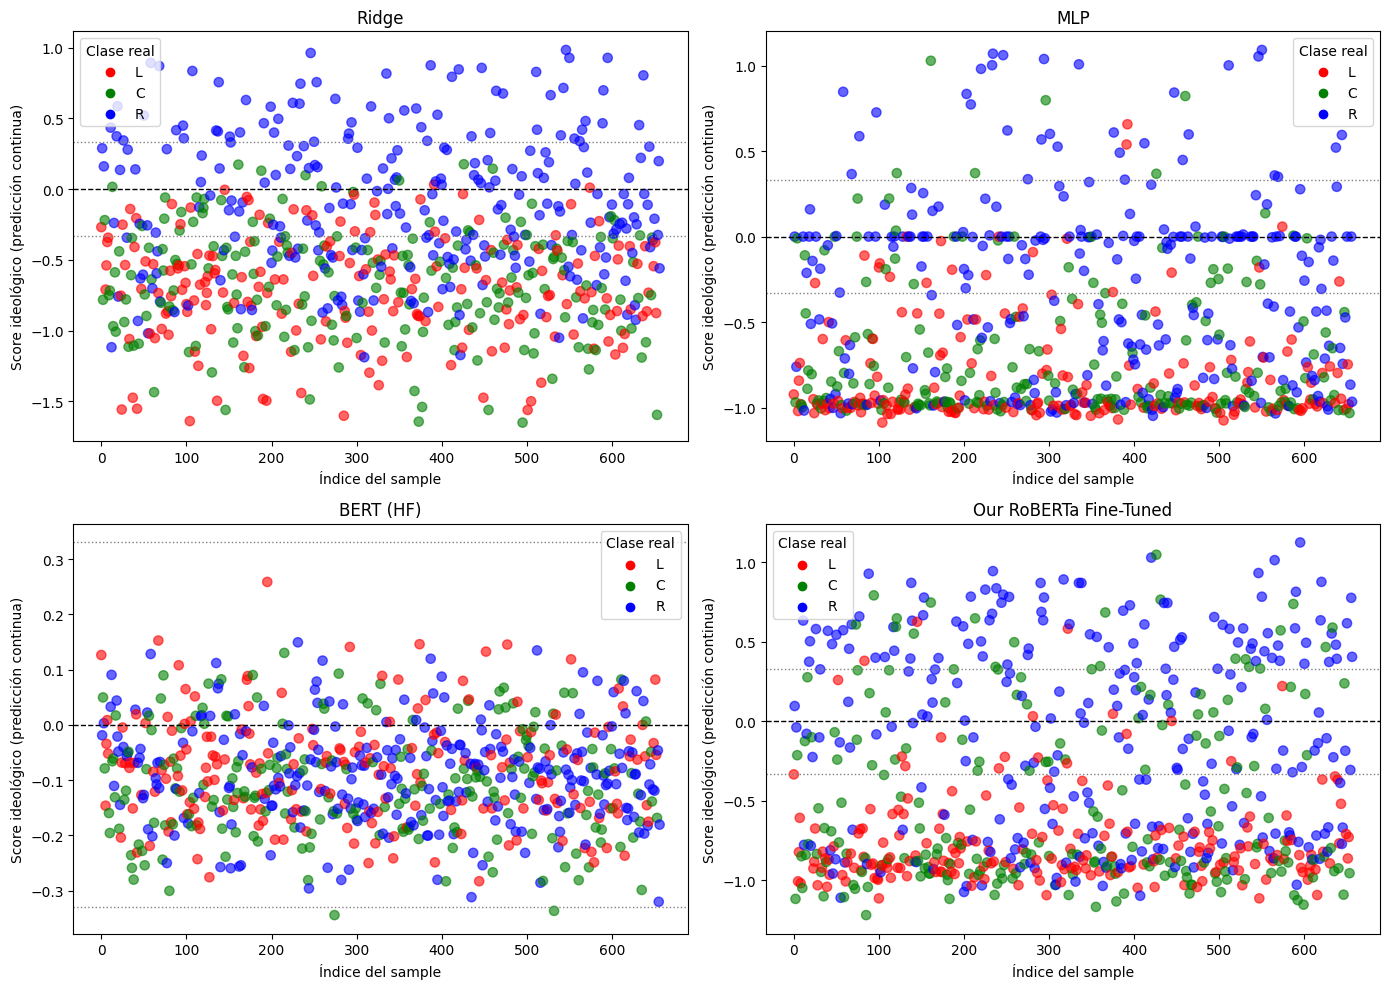

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
axes = ax.flatten()

plot_1d_predictions(y_caj_pred_ridge, y_caj, ax=axes[0], title="Ridge")
plot_1d_predictions(y_caj_pred_mlp, y_caj, ax=axes[1], title="MLP")
plot_1d_predictions(y_pred_bert, y_caj, ax=axes[2], title="BERT (HF)")
plot_1d_predictions(y_pred_roberta, y_caj, ax=axes[3], title="Our RoBERTa Fine-Tuned")
plt.tight_layout()